<IPython.core.display.Javascript object>


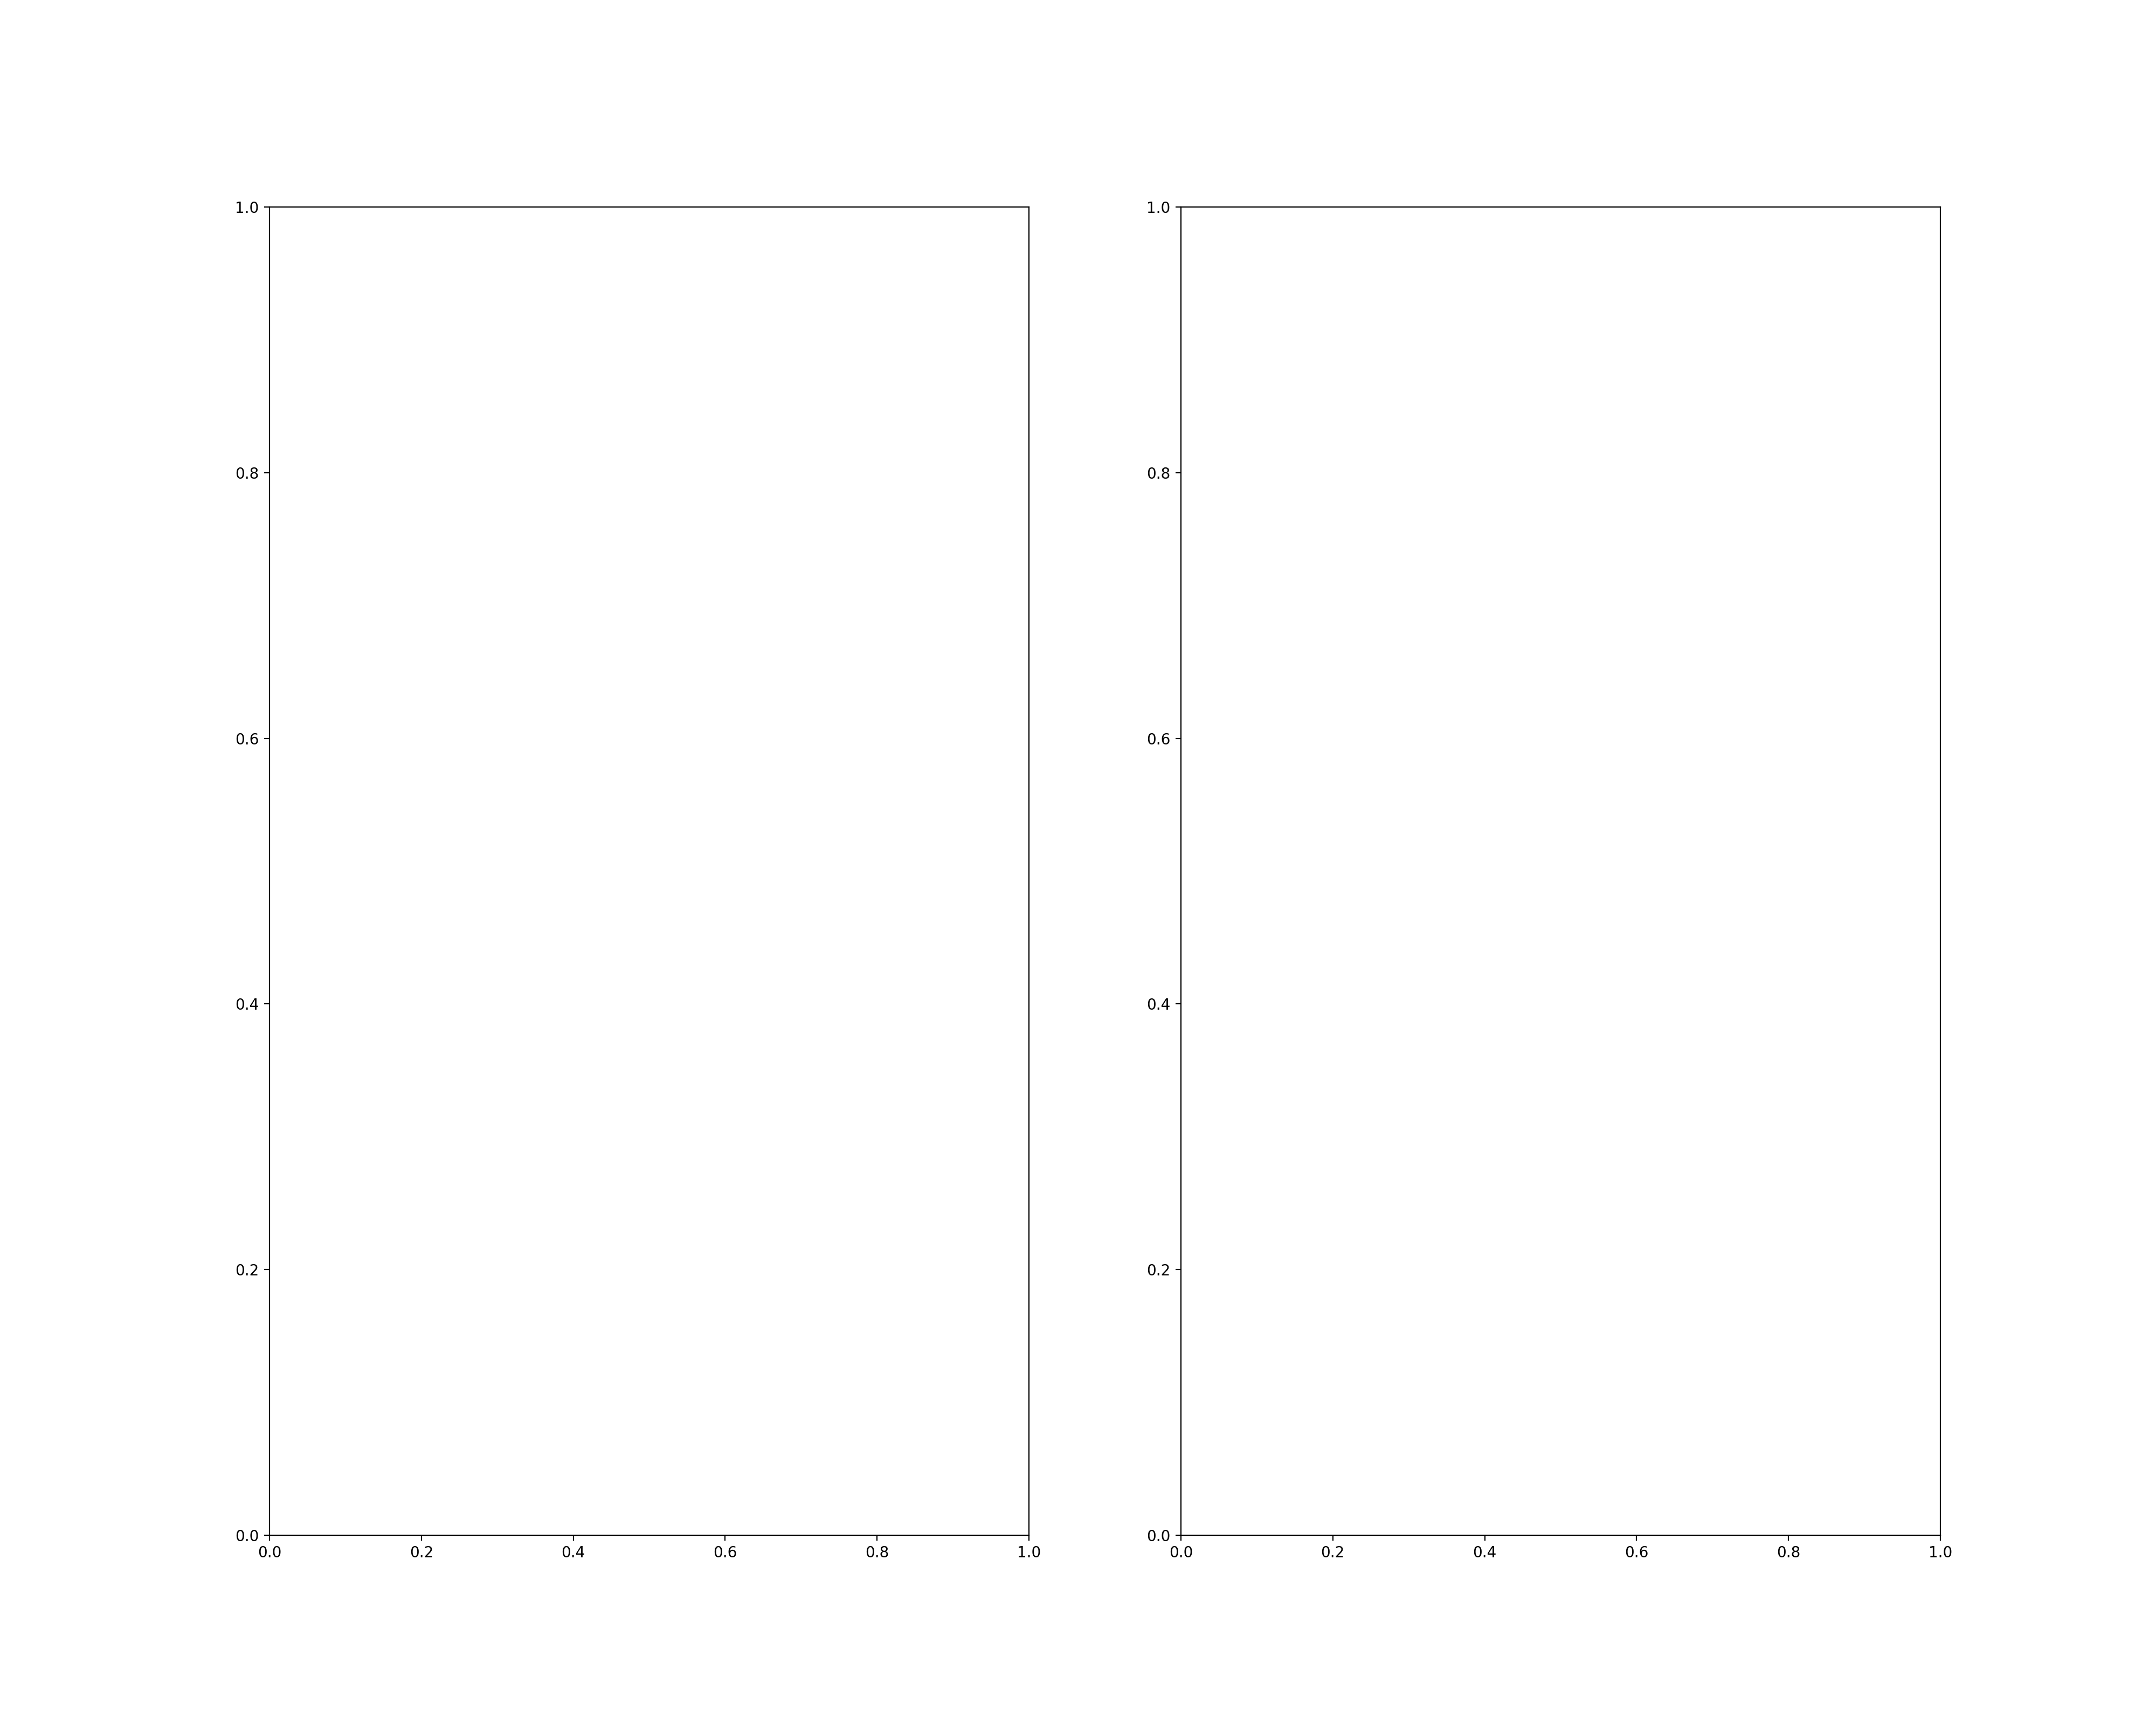

Loading the model
INFO:tensorflow:Restoring parameters from model/NYU_FCRN.ckpt


In [5]:
%matplotlib notebook

import argparse
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from easydict import EasyDict as edict
from PIL import Image
import cv2
import time
import models

# height = 228
# width = 304
height = 800
width = 1000
channels = 3
batch_size = 1
    
def load_model():

    # Create a placeholder for the input image

    input_node = tf.placeholder(tf.float32, shape=(None, height, width, channels))
    # Construct the network

    net = models.ResNet50UpProj({'data': input_node}, batch_size, 1, False)
    return  net, input_node

def plot_image(img_ori, pred):
    fig = plt.figure()
    plt.subplot(121)
    ii = plt.imshow(img_ori, interpolation='nearest')

    plt.subplot(122)

    ax = plt.gca()
    ii = ax.imshow(pred, interpolation='nearest')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ii, cax=cax)
    plt.show()
    
def predict_image(model_data_path, image_path, net, input_node):

    
    # Default input size
    height = 228
    width = 304
   
    # Read image
    img = Image.open(image_path)
    img = img.resize([width,height], Image.ANTIALIAS)
    img_ori = img.copy() 
    img = np.array(img).astype('float32')
    img = np.expand_dims(np.asarray(img), axis = 0)

    with tf.Session() as sess:

        # Load the converted parameters
        print('Loading the model')

        # Use to load from ckpt file
        saver = tf.train.Saver()     
        saver.restore(sess, model_data_path)

        # Use to load from npy file
#         net.load(model_data_path, sess) 

        # Evalute the network for the given image
    
        pred = sess.run(net.get_output(), feed_dict={input_node: img})
        
        # Plot result
        print(img.shape, pred.shape)
        plot_image(img_ori, pred[0,:,:,0])
        
        return pred
        
def read_video(filename):
    cap = cv2.VideoCapture(filename)
    i = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        print('get frame %d'%i)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
        yield frame
        i+=1

    cap.release()

def predict_video(model_data_path, video_path, net, input_node):

    
    # Default input size

    fig = plt.figure(figsize=(20, 16))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    timestamps = [time.time()]
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        print('Loading the model')

        saver = tf.train.Saver()     
        saver.restore(sess, model_data_path)
        for i, data in enumerate(read_video(video_path)):
            timestamps.append(time.time())

            print('Loading image costs %.3f s'%(timestamps[-1] - timestamps[-2]))
            # Read image
    #         img = Image.open(image_path)

    #         import pdb
    #         pdb.set_trace()
            img = Image.fromarray(data, 'RGB')
            img = img.resize([width,height], Image.ANTIALIAS)
            img_ori = img.copy()

            img = np.array(img).astype('float32')
            img = np.expand_dims(np.asarray(img), axis = 0)

            # Evalute the network for the given image
            pred = sess.run(net.get_output(), feed_dict={input_node: img})
#             out = np.zeros((height, width * 2, 3), dtype=np.uint8)
#             out[:height,:width,:] = img_ori
            npic = pred[0, :, :, 0]
            timestamps.append(time.time())
            print('Generate depth image costs %.3f s'%(timestamps[-1] - timestamps[-2]))
#             npic = cv2.resize(pred[0, :, :, 0], (width, height), interpolation=cv2.INTER_CUBIC)
#             npic = np.minimum(pic / 10 * 255, 255).astype(np.uint8)
#             out[:height,width:, 0] = npic
#             out[:height,width:, 1] = npic
#             out[:height,width:, 2] = npic

            # Plot result
            ax1.imshow(img_ori)
            ii = ax2.imshow(npic)
            divider = make_axes_locatable(ax2)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            bar = plt.colorbar(ii, cax=cax)
            plt.title('Frame %d'%i)

            fig.canvas.draw()
            ax1.clear()
            ax2.clear()
            bar.remove()
            timestamps.append(time.time())
            print('Draw image costs %.3f s'%(timestamps[-1] - timestamps[-2]))
    
def main():
    # Parse arguments
#     parser = argparse.ArgumentParser()
#     parser.add_argument('model_path', help='Converted parameters for the model')
#     parser.add_argument('image_paths', help='Directory of images to predict')
#     args = parser.parse_args()
    args = edict()
    tf.reset_default_graph()
    args.model_path = 'model/NYU_FCRN.ckpt'
    args.image_paths = 'images/test3.jpg'
    args.video_paths = 'images/IMG_1052.avi'

    # Predict the image
    net, input_node = load_model()
#     pred = predict_image(args.model_path, args.image_paths, net, input_node)
    pred = predict_video(args.model_path, args.video_paths, net, input_node)
#     os._exit(0)

if __name__ == '__main__':
    main()

        





In [ ]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))